<a href="https://colab.research.google.com/github/tinsaeabreham45/TR_on_CFAR_Image/blob/main/Transfer_learning_on_CFAR_IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

In [2]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# helper functions

plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize ='large')
plt.rc('ytick', left=False, right=False, labelsize ='large')
plt.rc('axes', facecolor='F8F8F8', titlesize ="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# function to display prediction image

def display_images(digit, predictions, labels, title):
    n = 10

    indexes = np.random.choice(len(predictions), size=n)

    n_digits = digit[indexes]
    n_predictions = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes]

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        class_index = n_predictions[i]

        plt.xlabel(classes[class_index])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n_digits[i])


def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)



In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


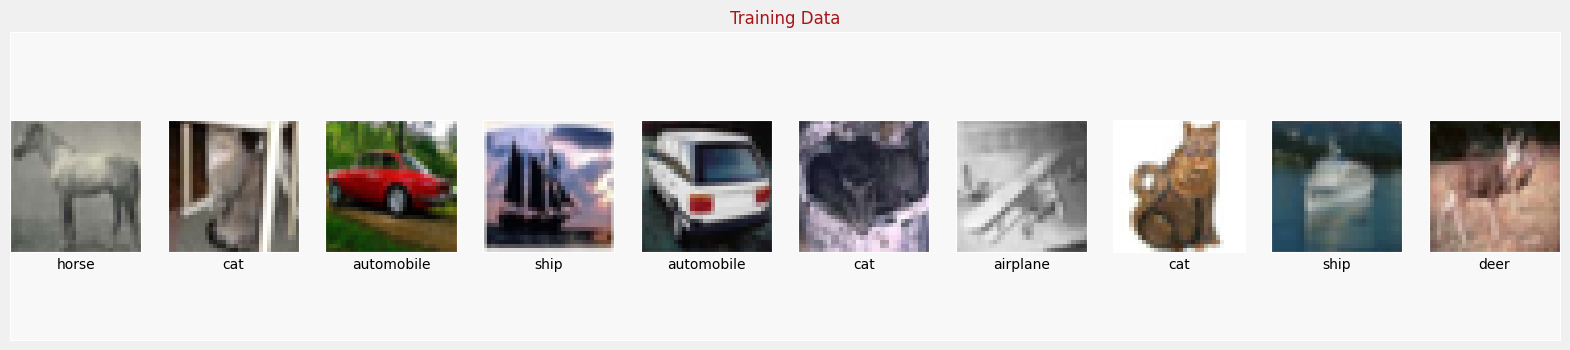

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )

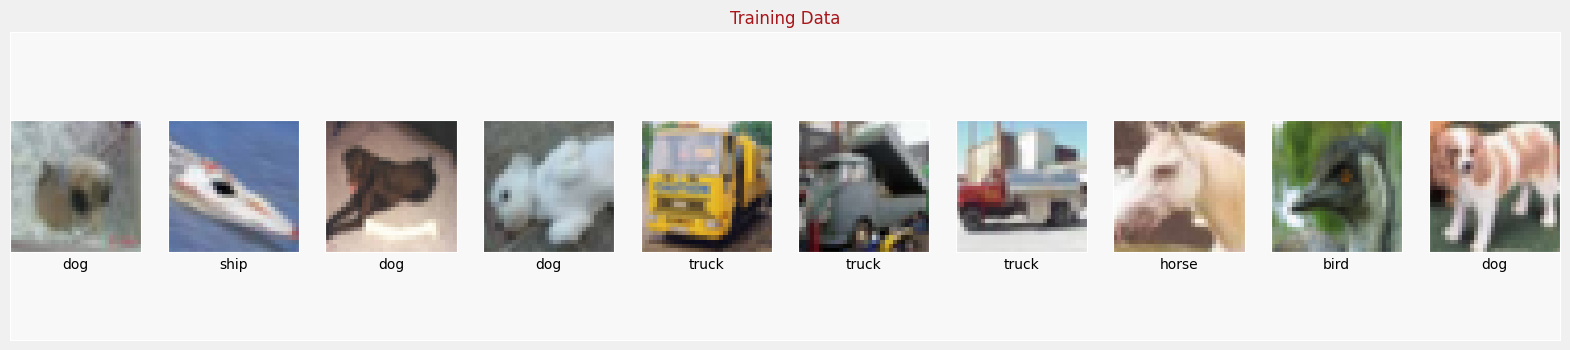

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [7]:
validation_images[0].astype('float32').shape

(32, 32, 3)

In [8]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [9]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [13]:
def feature_extractor(inputs):
    feature_extractor = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax', name="classification")(x)

    return x

def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)

    resent_feature_extractor = feature_extractor(resize)

    classification_output = classifier(resent_feature_extractor)

    return classification_output


def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 478s 562ms/step - accuracy: 0.7595 - loss: 0.7379 - val_accuracy: 0.9249 - val_loss: 0.2235
Epoch 2/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 423s 541ms/step - accuracy: 0.9646 - loss: 0.1072 - val_accuracy: 0.9477 - val_loss: 0.1510
Epoch 3/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 423s 541ms/step - accuracy: 0.9896 - loss: 0.0377 - val_accuracy: 0.9512 - val_loss: 0.1568
Epoch 4/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 442s 541ms/step - accuracy: 0.9968 - loss: 0.0144 - val_accuracy: 0.9450 - val_loss: 0.2098


# Model Evaluation

In [15]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9425 - loss: 0.2203


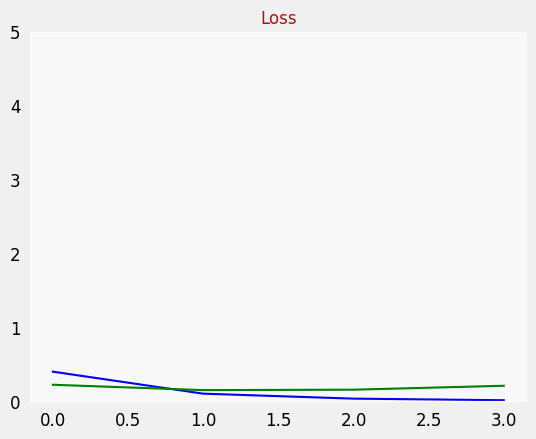

In [16]:
plot_metrics("loss", "Loss")

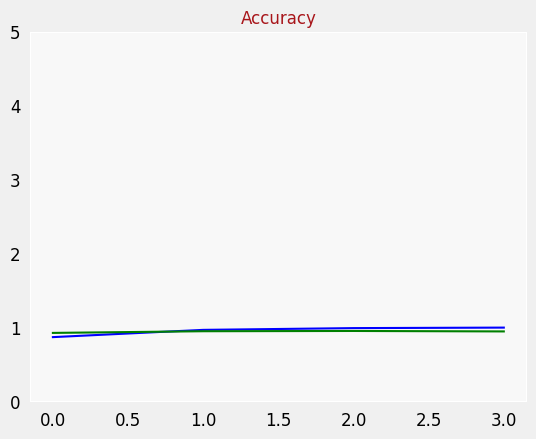

In [17]:
plot_metrics("accuracy", "Accuracy")

157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step


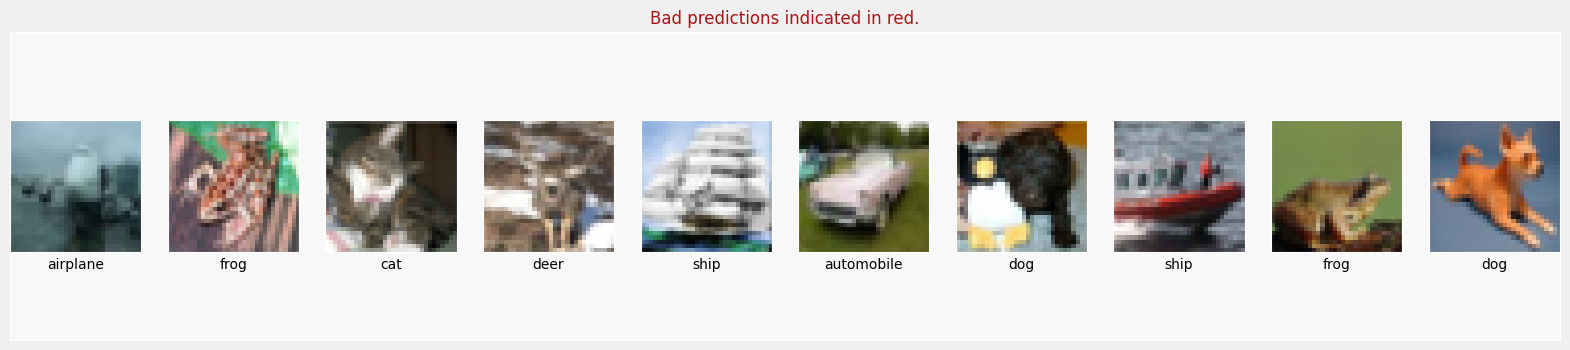

In [18]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")